# Investigating Machine Learning Models Performance for Interpolation of Meterological Data
### Eli Simic Robertson
### Sentient Hubs Internship Short Project

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import mean_squared_error
# add tftimeseries.py file path
import sys, os
sys.path.append(os.path.abspath(os.path.join('..', 'MastersDissertation', 'nbs', 'glassnode')))
from tftimeseries import *

RESPONSE_VAR = 'temperature'

%matplotlib inline

In [2]:
df_temp = pd.read_csv('./hourly_weather_kaggle/temperature.csv')
df_humid = pd.read_csv('./hourly_weather_kaggle/humidity.csv')
df_press = pd.read_csv('./hourly_weather_kaggle/pressure.csv')
df_wind_d = pd.read_csv('./hourly_weather_kaggle/wind_direction.csv')
df_wind_s = pd.read_csv('./hourly_weather_kaggle/wind_speed.csv')

# Make dataframe for all Los Angeles weather continuous data features
df = df_temp[['datetime', 'Los Angeles']].rename(columns={'Los Angeles': 'temperature'})

df = df.merge(df_humid[['datetime','Los Angeles']].rename(columns={'Los Angeles': 'humidity'}))
df = df.merge(df_press[['datetime','Los Angeles']].rename(columns={'Los Angeles': 'pressure'}))
df = df.merge(df_wind_d[['datetime','Los Angeles']].rename(columns={'Los Angeles': 'wind_d'}))
df = df.merge(df_wind_s[['datetime','Los Angeles']].rename(columns={'Los Angeles': 'wind_s'}))


df['datetime'] = pd.to_datetime(df['datetime'])

df.head(5)

,datetime,temperature,humidity,pressure,wind_d,wind_s
0,2012-10-01 12:00:00,NaN,NaN,NaN,NaN,NaN
1,2012-10-01 13:00:00,291.870000,88.0,1013.0,0.0,0.0
2,2012-10-01 14:00:00,291.868186,88.0,1013.0,0.0,0.0
3,2012-10-01 15:00:00,291.862844,88.0,1013.0,0.0,0.0
4,2012-10-01 16:00:00,291.857503,88.0,1013.0,0.0,0.0


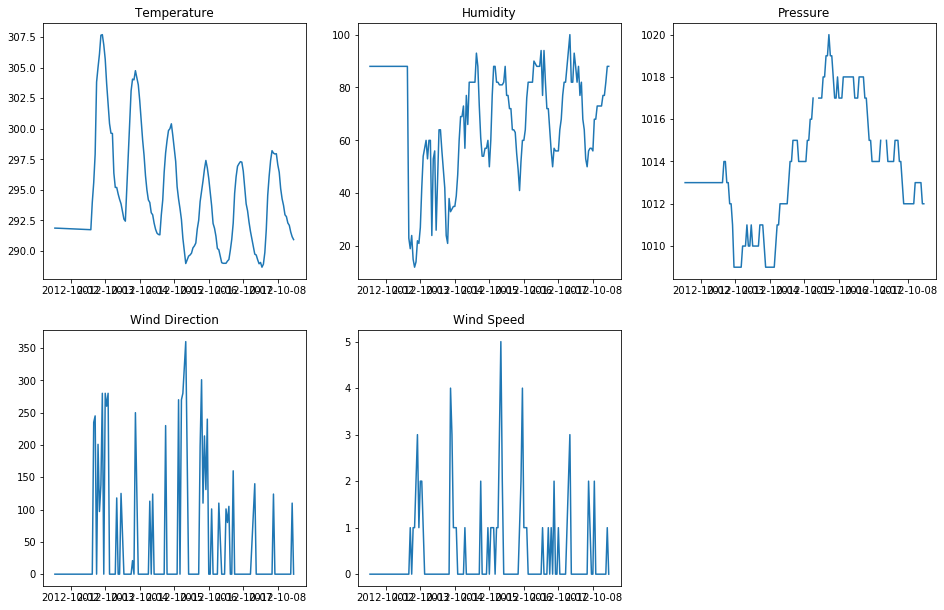

In [3]:
week = 24 * 7
df_1w = df.iloc[:week, :]

plt.figure(figsize=(16, 16))
plt.subplot(331)
plt.plot(df_1w['datetime'], df_1w['temperature'])
plt.title('Temperature')
plt.subplot(332)
plt.plot(df_1w['datetime'], df_1w['humidity'])
plt.title('Humidity')
plt.subplot(333)
plt.plot(df_1w['datetime'], df_1w['pressure'])
plt.title('Pressure')
plt.subplot(334)
plt.plot(df_1w['datetime'], df_1w['wind_d'])
plt.title('Wind Direction')
plt.subplot(335)
plt.plot(df_1w['datetime'], df_1w['wind_s'])
plt.title('Wind Speed');

In [4]:
df.isna().sum()

datetime         0
temperature      3
humidity       152
pressure       252
wind_d           1
wind_s           1
dtype: int64

In [5]:
252 / df.shape[0]

0.0055686915784588864

In [6]:
df = df.interpolate(method='linear').dropna()
df.isna().sum().sum()

0

#### Methodology 
- Create artificially noisy dataset
- Benchmark conventional interpolation techniques
- Train various Machine Learning models on Weather data to predict **Temperature**.
- Compare Model Predictions with Test dataset.
- Benchmark ML models performances against conventional interpolation techniques.

## Create Artificially Noisy Dataset
- Create 10% missing temperature data.

In [7]:
# Convert date col to numeric representation.
df = date_periodicity(df, date_col='datetime')

train_df, val_df, test_df = split_df(df)


noisy_test_df = test_df.copy()

In [8]:
noisy_test_df['temperature'].isna().sum()

0

In [9]:
noise_level = 0.2
n_gaps = int(noisy_test_df.shape[0] * noise_level)
# randomly choose gap indexes
gap_indxs = np.random.choice(a=noisy_test_df.shape[0], size=n_gaps, replace=False)

In [10]:
noisy_test_df['temperature'].iloc[gap_indxs] = np.nan

In [11]:
noisy_test_df['temperature'].isna().sum()

905

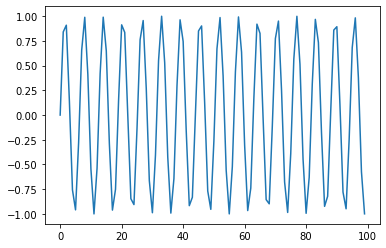

In [12]:
plt.plot(np.arange(noisy_test_df[:100].shape[0]), np.sin(np.arange(noisy_test_df[:100].shape[0])))

# plt.plot(np.arange(100), )

In [13]:
# generate a range of vals (0 ... n_rows)
idxs = np.arange(noisy_test_df.shape[0])
# generate a sin wave onto range
noisy_test_df_sin = np.sin(idxs) ** 2
# use sum as denominator to make the sin vals total to 1.
sum_idxs = np.sum(noisy_test_df_sin)

prob = noisy_test_df_sin / sum_idxs
# check the sum of sin's totals to 1.
assert int(np.sum(prob)) == 1

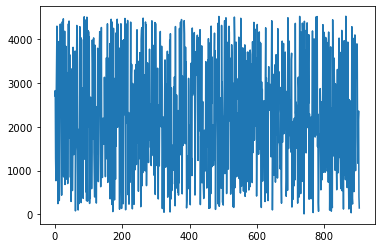

In [14]:
noise_level = 0.2
n_gaps = int(noisy_test_df.shape[0] * noise_level)
# randomly choose gap indexes
gap_indxs = np.random.choice(a=noisy_test_df.shape[0], size=n_gaps, replace=False, p=prob)

plt.plot(gap_indxs)

In [15]:
noisy_test_df = test_df.copy()

noisy_test_df['temperature'].iloc[gap_indxs] = np.nan

#### Plotting Noisy Data

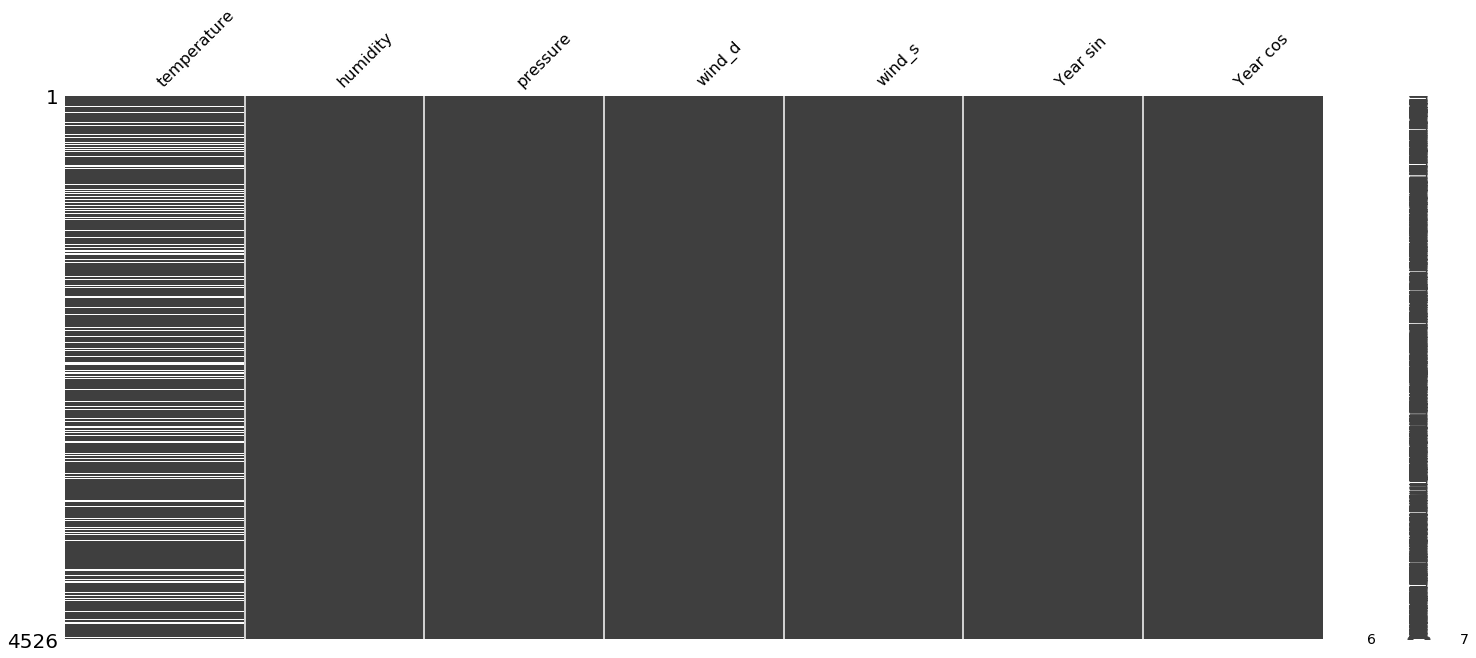

In [16]:
import missingno as msno

msno.matrix(noisy_test_df);

In [20]:
methods = ['linear', 'index', 'pad', 'nearest', 'zero', 'slinear', 'quadratic', 'cubic', 'spline',
           'polynomial', 'piecewise_polynomial', 'spline', 'pchip', 'akima',
      'cubicspline', 'from_derivatives']

mses = []

for method in methods:
    order = 2
    temp_int = noisy_test_df['temperature'].interpolate(method=method, order=order)
    # fill if method creates NA val
    temp_int = temp_int.fillna(method='bfill').fillna(method='ffill')
    mse = mean_squared_error(test_df['temperature'], temp_int)

    mses.append(mse)

In [21]:
pd.DataFrame({"method": methods, "MSE": mses}).sort_values(by='MSE', ascending=True)

,method,MSE
12,pchip,0.065382
13,akima,0.065650
7,cubic,0.071253
14,cubicspline,0.071524
6,quadratic,0.071545
9,polynomial,0.071545
0,linear,0.075542
1,index,0.075542
10,piecewise_polynomial,0.075542
15,from_derivatives,0.075542


## Linear Model

In [22]:
train_df.dtypes

temperature    float64
humidity       float64
pressure       float64
wind_d         float64
wind_s         float64
Year sin       float64
Year cos       float64
dtype: object

In [23]:
train_df, val_df, test_df = split_df(df)

# num_features = df.shape[1]

train_df, val_df, test_df, scaler = scale_datasets(train_df, val_df,
                                                   test_df, dependent=RESPONSE_VAR)

#### Windowing data

In [24]:
wide_window = WindowGenerator(
    input_width=7, label_width=7, shift=1,
    label_columns=[RESPONSE_VAR],
    train_df=train_df,
    val_df=val_df,
    test_df=test_df)

wide_window

Total window size: 8
Input indices: [0 1 2 3 4 5 6]
Label indices: [1 2 3 4 5 6 7]
Label column name(s): ['temperature']

In [25]:
linear = tf.keras.Sequential([
    tf.keras.layers.Dense(units=1)
])

compile_and_fit(linear, wide_window)

Epoch 1/20
990/990 [==============================] - 2s 1ms/step - loss: 71881.6562 - mean_absolute_error: 259.2942 - mean_absolute_percentage_error: 89.3631 - val_loss: 23118.5703 - val_mean_absolute_error: 152.0095 - val_mean_absolute_percentage_error: 52.1877
Epoch 2/20
990/990 [==============================] - 1s 1ms/step - loss: 7988.7451 - mean_absolute_error: 82.4069 - mean_absolute_percentage_error: 28.3997 - val_loss: 1061.0582 - val_mean_absolute_error: 32.5189 - val_mean_absolute_percentage_error: 11.1653
Epoch 3/20
990/990 [==============================] - 1s 1ms/step - loss: 234.6457 - mean_absolute_error: 12.5596 - mean_absolute_percentage_error: 4.3280 - val_loss: 9.0630 - val_mean_absolute_error: 2.4484 - val_mean_absolute_percentage_error: 0.8415
Epoch 4/20
990/990 [==============================] - 1s 1ms/step - loss: 4.3452 - mean_absolute_error: 1.5511 - mean_absolute_percentage_error: 0.5345 - val_loss: 3.4924 - val_mean_absolute_error: 1.3601 - val_mean_absolut

In [26]:
wide_window.test_df[:7]

,temperature,humidity,pressure,wind_d,wind_s,Year sin,Year cos
40727,288.73,0.081420,-0.822047,1.205877,-0.026447,0.808989,-1.254875
40728,288.48,0.949324,-0.822047,1.301043,1.530699,0.808191,-1.255500
40729,288.56,0.264136,-0.822047,-1.268448,-0.026447,0.807393,-1.256125
40730,288.65,0.492532,-0.822047,0.920378,-0.026447,0.806594,-1.256749
40731,288.98,0.264136,-0.707277,-1.268448,0.752126,0.805794,-1.257373
40732,289.09,0.081420,-0.707277,0.444546,0.752126,0.804994,-1.257996
40733,289.66,0.081420,-0.707277,-1.268448,1.530699,0.804194,-1.258618


In [27]:
# preds = linear.predict(wide_window.test_df[nan_indx - 7: nan_indx])

# preds

NameError: name 'nan_indx' is not defined

In [ ]:
# mean_squared_error(preds, test_df)

### Convert Predictions into Interpolation Function
- find nans indexes 
- get preceeding 7 indexes for nan indexes, if index < 7 => interpolate with conventional method
- feed 7 size window to model
- merge prediction into noisy dataframe

In [104]:
def model_interpolate(model, noisy_test_df, window_size=7):
    
    noisy_test_df.iloc[:window_size] = noisy_test_df.iloc[:window_size].interpolate(method='akima')
    noisy_test_array = noisy_test_df['temperature'].to_numpy()
    
    # get indexs of nan values, index to 0th dimension (ugly)
    nan_indxs = np.where(np.isnan(noisy_test_array))[0]

    for nan_indx in nan_indxs:
        # Make a prediction for the NaN
        preds = model.predict(wide_window.test_df[nan_indx - window_size: nan_indx])
        # Insert the pred inplace of the NaN
        np.put(noisy_test_array, nan_indx, preds[-1])
        
    return noisy_test_array

In [105]:
noisy_test_array = model_interpolate(linear, noisy_test_df)

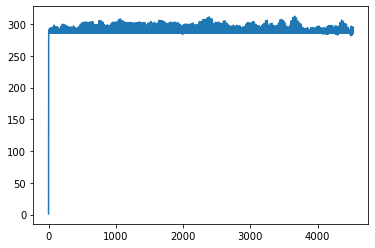

In [109]:
plt.plot(noisy_test_array)

In [110]:
mean_squared_error(test_df['temperature'][1:], noisy_test_array[1:])

22.102839201699283